<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/2_Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [44]:
org = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo/new_dataset.csv')

In [4]:
df = org

df.dropna(inplace = True)
df.drop('date', axis=1, inplace=True)

print(len(df))
df.head()

42745


,cpt_cyc_protocoles,nb_total_pieces,cpt_cyc_machine,temps_cycle,temps_dosage,temps_injection,pression_com,volume_com,matelas,val_pointe,integral,duration,pression,volume,label
0,7583,30688,7672,27.50,0.00,3.57,779,16.50,10.87,1062,76,31.07,1841,27.37,0
1,7585,30696,7674,27.28,4.36,3.57,1332,16.50,16.28,1344,125,35.21,2676,32.78,1
2,7587,30732,7683,26.98,4.09,3.55,1354,16.50,16.26,1374,130,34.62,2728,32.76,1
3,7589,30740,7685,26.98,4.09,3.56,1350,16.50,16.27,1369,127,34.63,2719,32.77,1
4,7592,30752,7688,26.94,4.06,3.56,1359,16.49,16.27,1381,128,34.56,2740,32.76,1


## Feature selection with Filter methods: Variance threshold


In [ ]:
#A point beyond which there is a change in the manner a program executes

In [ ]:
# It removes all features which variance doesn’t meet some threshold.
# By default, it removes all zero-variance features, i.e., features that have the same value in all samples. 
# We assume that features with a higher variance may contain more useful information, but note that we are
# not taking the relationship between feature variables or feature and target variables into account, which 
# is one of the drawbacks of filter methods.

In [13]:
from sklearn.feature_selection import VarianceThreshold

df_variance_threshhold = df.drop(['duration'], axis = 1)
df_variance_threshhold.head()

#why threshold = 0.5 ?
vt = VarianceThreshold(threshold=0.1)
vt.fit(df_variance_threshhold)

mask = vt.get_support()
variance_threshhold_chosen_features = list(df_variance_threshhold.loc[:, mask].columns)
removed_features = [feature for feature in df_variance_threshhold.columns if feature not in variance_threshhold_chosen_features]

print('Chosen features: {}'.format(variance_threshhold_chosen_features))
print('Removed features: {}'.format(removed_features))
print(variance_threshhold_chosen_features)

Chosen features: ['cpt_cyc_protocoles', 'nb_total_pieces', 'cpt_cyc_machine', 'pression_com', 'val_pointe', 'integral', 'pression']
Removed features: ['temps_cycle', 'temps_dosage', 'temps_injection', 'volume_com', 'matelas', 'volume', 'label']
['cpt_cyc_protocoles', 'nb_total_pieces', 'cpt_cyc_machine', 'pression_com', 'val_pointe', 'integral', 'pression']


## Feature selection with Wrapper methods: XGBOOST Rfe



In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from matplotlib import pyplot
from xgboost import XGBRegressor

def feature_ranking_rfe(model, df):
 
  #number of features
  nof_list=np.arange(1,24)            
  high_score=0

  nof=0           
  score_list =[]

  X = df.drop(['duration'], axis=1)
  y = df['duration']

  for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # normalize the input values
    mms = MinMaxScaler()
    X_train = mms.fit_transform(X_train)
    X_test = mms.transform(X_test)

    rfe = RFE(estimator=model, n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score > high_score):
        high_score = score
        nof = nof_list[n]

  #calculating with the optimal number
  cols = list(X.columns)
  rfe = RFE(estimator=model, n_features_to_select=nof)
  X_rfe = rfe.fit_transform(X,y)  
  model.fit(X_rfe,y)              
  temp = pd.Series(rfe.support_,index = cols)
  selected_features_rfe = temp[temp==True].index

  features = { 'Model': model.__class__.__name__,
      'Number of features':  nof,
          'Highest feature score': high_score,
          'Selected features': [selected_features_rfe]}
  
  features = pd.DataFrame(features)
  ranking = pd.DataFrame(zip(X.columns, rfe.ranking_), columns=['Feature', 'Ranking']).sort_values('Ranking')

  if model.__class__.__name__ == 'LinearRegression':
    importance = model.coef_
  else:
    importance = model.feature_importances_  
    
  for feature, score in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (feature,score))
    
  pyplot.bar([x for x in range(len(importance))], importance)
  pyplot.show() 

  return features, ranking


Feature: 0, Score: 0.00510
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.38282
Feature: 4, Score: 0.55622
Feature: 5, Score: 0.00552
Feature: 6, Score: 0.04778
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00117
Feature: 9, Score: 0.00054
Feature: 10, Score: 0.00085
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000


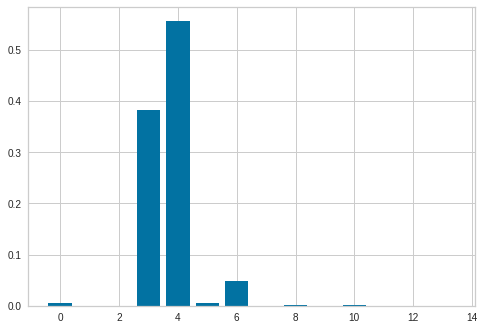

,Model,Number of features,Highest feature score,Selected features
0,XGBRegressor,15,0.998573,"Index(['cpt_cyc_protocoles', 'nb_total_pieces'..."


In [33]:
model = XGBRegressor(objective ='reg:squarederror', 
                     tree_method = "hist",
                     verbosity = 0,  
                     n_jobs=-1)
 
xgbRegressor_rfe_features, ranking = feature_ranking_rfe(model,df)
xgbRegressor_rfe_features

In [36]:
len(df.columns)

15

In [34]:
xgbRegressor_rfe_features['Selected features'].values

array([Index(['cpt_cyc_protocoles', 'nb_total_pieces', 'cpt_cyc_machine',
              'temps_cycle', 'temps_dosage', 'temps_injection', 'pression_com',
              'volume_com', 'matelas', 'val_pointe', 'integral', 'pression', 'volume',
              'label'],
             dtype='object')                                                          ],
      dtype=object)

## Feature selection with Embedded methods: Lasso

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66.02809348650794, tolerance: 4.757330482442394
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 150.28950005407523, tolerance: 4.757330482442394
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235.55299015551896, tolerance: 4.757330482442394
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 317.264875

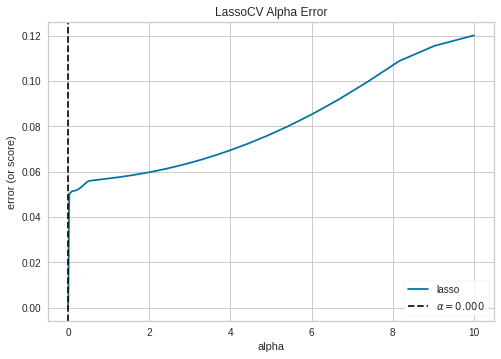

In [29]:
#https://www.scikit-yb.org/en/latest/api/regressor/alphas.html
import numpy as np

from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection

X = df.drop(['duration'], axis=1)
y = df['duration']

# Create a list of alphas to cross-validate against
alphas = np.logspace(-10, 1, 250)

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas, tol=0.001)
visualizer = AlphaSelection(model)
visualizer.fit(X, y)
visualizer.show()

In [30]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

X = df.drop(['label'], axis=1)
y = df['label']

# Lasso (l1) penalty.
# The selectFromModel class from sklearn, which  will select the features which coefficients are non-zero

selector = SelectFromModel(linear_model.Lasso(alpha=0.0000))
selector.fit(X, y)

selected_feat = X.columns[(selector.get_support())]

print('total features: {}'.format((X.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(
            np.abs(selector.estimator_.coef_) > np.abs(
                selector.estimator_.coef_).mean())))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_from_model.py:267: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


total features: 14
selected features: 11
features with coefficients greater than the mean coefficient: 2


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e+02, tolerance: 3.166e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


In [31]:
selected_feat

Index(['temps_cycle', 'temps_dosage', 'temps_injection', 'pression_com',
       'volume_com', 'matelas', 'val_pointe', 'integral', 'duration',
       'pression', 'volume'],
      dtype='object')

## Methods comparaison using KNN classifier

In [37]:
variance_df = df[variance_threshhold_chosen_features]
variance_df[['label']] = df[[ 'label' ]]


lasso_df = df[selected_feat]
lasso_df[['label']] = df[[ 'label' ]]

XGB_df = df

all_dfs = [df,variance_df, XGB_df, lasso_df]

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [38]:
data = {'Method':  ['Filter',
                          'Wrapper',
                          'Embedded'],
        'Algorithm': ['variance threshhold', 
                  'XGBOOST', 
                  'Lasso'],
        'Number of selected features': [len(variance_df.columns),
                              len(XGB_df.columns),
                              len(lasso_df.columns)],
        'Selected features': [variance_df.columns,
                              XGB_df.columns,
                              lasso_df.columns]
        }

feature_analysis = pd.DataFrame(data)

feature_analysis.to_csv( "/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_selected_features.csv", index=False, encoding='utf-8')
feature_analysis

,Method,Algorithm,Number of selected features,Selected features
0,Filter,variance threshhold,8,"Index(['cpt_cyc_protocoles', 'nb_total_pieces'..."
1,Wrapper,XGBOOST,15,"Index(['cpt_cyc_protocoles', 'nb_total_pieces'..."
2,Embedded,Lasso,12,"Index(['temps_cycle', 'temps_dosage', 'temps_i..."


In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
best_params = 0
model = 0
accuracy = 0
i = 0
max = {'dataset': i, 'accuracy': accuracy, 'best_params': best_params}

for df in all_dfs:
  X = df.drop(['label'], axis=1)
  y = df['label']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  mms = MinMaxScaler()
  X_train = mms.fit_transform(X_train)
  X_test = mms.transform(X_test)

  grid_params = {
      'n_neighbors' : [5, 7, 11, 19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train, y_train)
  y_test_hat=model.predict(X_test) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100
  if accuracy  < test_accuracy:
    accuracy = test_accuracy
    max = { 'dataset': i, 'accuracy': accuracy, 'best_params': best_params }
  print(i,test_accuracy)
  #ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test)
   
  y_pred_proba = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('roc',roc_auc_score(y_test,y_pred_proba))

  print(classification_report(y_test,y_pred))
  print('_______________________________________________')
  i = i + 1

print(max)



0 99.85963817841547
roc 0.9827698506738237
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        88
           1       1.00      1.00      1.00     12736

    accuracy                           1.00     12824
   macro avg       0.97      0.92      0.95     12824
weighted avg       1.00      1.00      1.00     12824

_______________________________________________
1 99.84404242046163
roc 0.9636700794229426
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        83
           1       1.00      1.00      1.00     12741

    accuracy                           1.00     12824
   macro avg       0.97      0.91      0.94     12824
weighted avg       1.00      1.00      1.00     12824

_______________________________________________
2 99.83624454148472
roc 0.9504057554006505
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        91
           1

In [40]:
import pickle

# save the model to disk
filename = '/content/gdrive/MyDrive/Datascience/PFE/addixo_knn_classifier.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9994541484716157


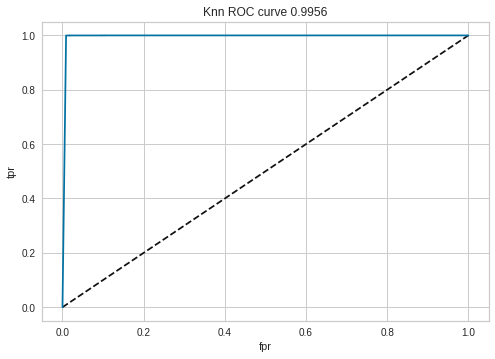

In [41]:
#Area under ROC curve
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn ROC curve %.4f' %(roc_auc_score(y_test,y_pred_proba)))
plt.show()

In [42]:
lasso_df

,temps_cycle,temps_dosage,temps_injection,pression_com,volume_com,matelas,val_pointe,integral,duration,pression,volume,label
0,27.50,0.00,3.57,779,16.50,10.87,1062,76,31.07,1841,27.37,0
1,27.28,4.36,3.57,1332,16.50,16.28,1344,125,35.21,2676,32.78,1
2,26.98,4.09,3.55,1354,16.50,16.26,1374,130,34.62,2728,32.76,1
3,26.98,4.09,3.56,1350,16.50,16.27,1369,127,34.63,2719,32.77,1
4,26.94,4.06,3.56,1359,16.49,16.27,1381,128,34.56,2740,32.76,1
...,...,...,...,...,...,...,...,...,...,...,...,...
42740,27.03,4.05,3.49,1349,16.50,16.34,1367,143,34.57,2716,32.84,1
42741,27.07,4.02,3.48,1343,16.50,16.34,1361,144,34.57,2704,32.84,1
42742,27.07,4.03,3.48,1349,16.50,16.34,1369,143,34.58,2718,32.84,1
42743,27.05,4.04,3.48,1352,16.50,16.40,1365,144,34.57,2717,32.90,1


In [45]:
lasso_df.insert(0,'date',org['date'])
lasso_df.to_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_chosen_dataset_lasso.csv', index=False)

In [46]:
lasso_df

,date,temps_cycle,temps_dosage,temps_injection,pression_com,volume_com,matelas,val_pointe,integral,duration,pression,volume,label
0,2022-02-01 22:30:00,27.50,0.00,3.57,779,16.50,10.87,1062,76,31.07,1841,27.37,0
1,2022-02-01 22:31:00,27.28,4.36,3.57,1332,16.50,16.28,1344,125,35.21,2676,32.78,1
2,2022-02-01 22:35:00,26.98,4.09,3.55,1354,16.50,16.26,1374,130,34.62,2728,32.76,1
3,2022-02-01 22:36:00,26.98,4.09,3.56,1350,16.50,16.27,1369,127,34.63,2719,32.77,1
4,2022-02-01 22:37:00,26.94,4.06,3.56,1359,16.49,16.27,1381,128,34.56,2740,32.76,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42740,2022-03-28 12:22:00,27.03,4.05,3.49,1349,16.50,16.34,1367,143,34.57,2716,32.84,1
42741,2022-03-28 12:23:00,27.07,4.02,3.48,1343,16.50,16.34,1361,144,34.57,2704,32.84,1
42742,2022-03-28 12:24:00,27.07,4.03,3.48,1349,16.50,16.34,1369,143,34.58,2718,32.84,1
42743,2022-03-28 12:25:00,27.05,4.04,3.48,1352,16.50,16.40,1365,144,34.57,2717,32.90,1
